In [4]:

import tensorflow as tf
import os
import pathlib
import time
import datetime
import matplotlib.pyplot as plt
from IPython import display

In [5]:
dataset_name = "facades"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'
path_to_zip = tf.keras.utils.get_file(
    fname=f'{dataset_name}.tar.gz',
    origin=_URL,
    extract=True)

path_to_zip = pathlib.Path(path_to_zip)
PATH = path_to_zip.parent/dataset_name

In [6]:
list(PATH.parent.iterdir())

[WindowsPath('C:/Users/Aakar/.keras/datasets/facades'),
 WindowsPath('C:/Users/Aakar/.keras/datasets/facades.tar.gz')]

In [7]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.io.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w //2
    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image=  tf.cast(real_image, tf.float32)
    return input_image, real_image

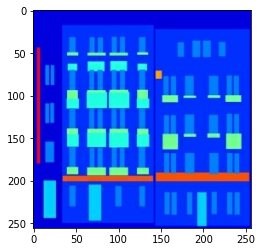

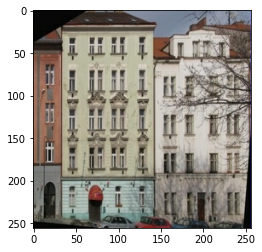

In [38]:
inp, re = load(str(PATH / 'train/101.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [39]:
BATCH_SIZE = 1
BUFFER_SIZE=  400
IMG_WIDTH = 256
IMG_HEIGHT = 256

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


def normalize(input_image, real_image):
    input_image=  (input_image / 127.5) - 1
    real_image = (real_image/127.5) - 1
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

In [40]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

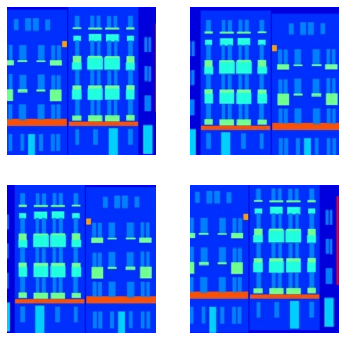

In [41]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [42]:
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image , real_image

In [43]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [44]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [26]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides = 2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer= tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result


In [30]:
from turtle import down


def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=True),
        downsample(128, 4),
        downsample(128, 4),
        downsample(128, 4)
    ]

    up_stack = [
        upsample(128, 4, apply_dropout=True),
        upsample(128, 4, apply_dropout=True),
        upsample(128, 4),
        upsample(64, 4)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [31]:
generator = Generator()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


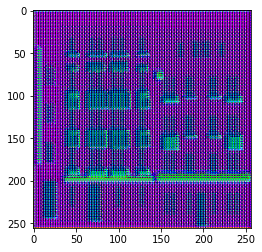

In [45]:
o = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(o[0, ...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


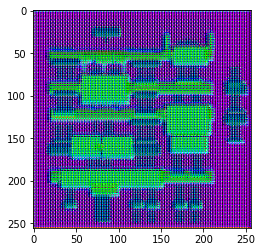

In [36]:
plt.imshow(o[0, ...])

In [37]:
inp

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[  7.,   6., 172.],
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        ...,
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        [  0.,   0., 222.]],

       [[  7.,   6., 172.],
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        ...,
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        [  0.,   0., 222.]],

       [[  7.,   6., 172.],
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        ...,
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        [  0.,   0., 222.]],

       ...,

       [[  7.,   6., 172.],
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        ...,
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        [  0.,   0., 222.]],

       [[  7.,   6., 172.],
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        ...,
        [  0.,   0., 222.],
        [  0.,   0., 222.],
        [  0.,   0., 222.]],

       [[  7.,   